# LJ Tutorial 

Environment setup
```
git clone git@github.com:jennyfothergill/msibi.git
cd msibi
conda env create -f environment.yml
conda activate msibi
pip install -e .
#cd ../
#git clone git@github.com:jennyfothergill/msibi_utils.git
#cd msibi_utils
#pip install -e .
```


In [6]:
import itertools
import os

import numpy as np

from msibi import MSIBI, State, Pair, mie

Remove old runs

In [3]:
os.system('rm state*/_* rdfs/pair* potentials/* f_fits.log state*/log.txt')
os.system('rm state*/err.txt')
os.system('rm state*/query.dcd')

0

Set up global parameters:

- rdf_cutoff specifies how far out to calculate the rdf
- pot_cutoff specifies where to cut off the IBI calculation of the potential. The tail of the potential function (by default the last 5 points will be smoothed to zero using the [XPLOR smoothing function](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.pair). Small r values of the potential are also corrected using a linear correction by default. 
- smooth_rdfs if True, applies a Savitzky-Golay filter to the rdf array

In [ ]:
rdf_cutoff = 5.0
opt = MSIBI(rdf_cutoff=rdf_cutoff, n_rdf_points=101, pot_cutoff=3.0,
        smooth_rdfs=True)

Specify states

In [8]:
state0 = State(kT=0.5, state_dir='./state0', top_file='start.hoomdxml',
               name='state0', backup_trajectory=True)
state1 = State(kT=1.5, state_dir='./state1', top_file='start.hoomdxml',
               name='state1', backup_trajectory=True)
state2 = State(kT=2.0, state_dir='./state2', top_file='start.hoomdxml',
               name='state2', backup_trajectory=True)
states = [state0, state1, state2]

Specify pairs

In [9]:
# all-all for 1468 atoms
indices = list(itertools.combinations(range(1468), 2))  
# 1-D array of potential values.
initial_guess = mie(opt.pot_r, 1.0, 1.0)  
rdf_targets = [
    np.loadtxt('rdfs/rdf.target{0:d}.t1t1.txt'.format(i)) for i in range(3)
]

pair0 = Pair('1', '1', initial_guess)
alphas = [1.0, 1.0, 1.0]

/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)
/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: invalid value encountered in subtract
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)


Add targets to pair

In [10]:
for state, target, alpha in zip(states, rdf_targets, alphas):
    pair0.add_state(state, target, alpha, indices)
pairs = [pair0]  # optimize() expects a list of pairs

Implement MSIBI algorithm

In [8]:
opt.optimize(states, pairs, n_iterations=5, engine='hoomd')

[INFO] -------- Iteration 0 --------
[INFO] Launching 4 CPU threads...
[INFO]     Running state state1 on CPU
[INFO]     Running state state2 on CPU
[INFO]     Running state state0 on CPU
[INFO]     Launched HOOMD in ./state1
[INFO]     Launched HOOMD in ./state2
[INFO]     Launched HOOMD in ./state0
[INFO]     Finished in ./state2.
[INFO]     Finished in ./state0.
[INFO]     Finished in ./state1.
[INFO] pair 1-1, state state0, iteration 0: 0.958386
[INFO] pair 1-1, state state1, iteration 0: 0.990612
[INFO] pair 1-1, state state2, iteration 0: 0.993164
/Users/jenny/Projects/msibi/msibi/pair.py:189: RuntimeWarning: invalid value encountered in true_divide
  self.potential += (kT * alpha * np.log(current_rdf / target_rdf) /
[INFO] -------- Iteration 1 --------
[INFO] Launching 4 CPU threads...
[INFO]     Running state state0 on CPU
[INFO]     Running state state1 on CPU
[INFO]     Running state state2 on CPU
[INFO]     Launched HOOMD in ./state0
[INFO]     Launched HOOMD in ./state1
[IN

Plot results

In [2]:
import matplotlib.pyplot as plt

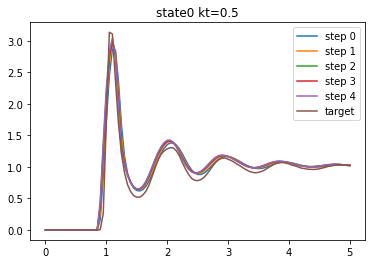

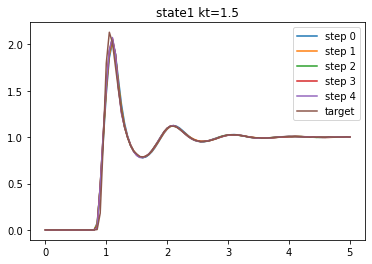

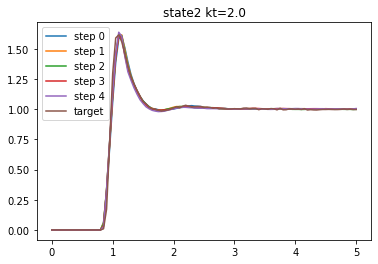

In [45]:
for state in states:
    plt.title(f'{state.name} kt={state.kT}')
    
    for step in range(0,opt.n_iterations):
        try:
            step_rdf = np.loadtxt(f'rdfs/pair_1-1-state_{state.name}-step{step}.txt')
            plt.plot(step_rdf[:,0],step_rdf[:,1], label=f'step {step}')
        except OSError:
            target = np.loadtxt(f'rdfs/rdf.target{state.name.strip("state")}.t1t1.txt')
            plt.plot(target[:,0], target[:,1], label='target')
            plt.legend()
            plt.show()
            break

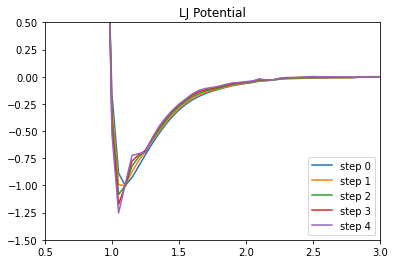

In [60]:
for step in range(0,opt.n_iterations):
    plt.ylim([-1.5,0.5])
    plt.xlim([0.5,3])
    plt.title("LJ Potential")
    try:
        step_pot = np.loadtxt(f'potentials/step{step}.pot.1-1.txt')
        plt.plot(step_pot[:,0],step_pot[:,1], label=f'step {step}')
    except OSError:
        plt.legend()
        plt.show()
        break

what potential was used to generate the targets?